# 01_Data_Extraction

This file imports the raw data files (tifs, geojsons, csv files) for each location. 
The files are split into training, validation, and test 

### Disclaimer

This file adapts code that was kindly provided to us by Lukas Franken. The code strucutre has remained the same but was debugged and changed to support our needs (e.g. data splitting into train/val/test; prefixing etc). The visualization function is self-produced



## Package import

In [ ]:
! pip install --upgrade setuptools
! pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#! pip uninstall opencv-python
! pip install opencv-python
! pip install geopandas
! pip install rtree
! pip install fiftyone
! pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 34.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13

In [ ]:
# installation of gdal is very messy, has to be done via terminal and multiple steps

In [ ]:
global resolutions

# precomputed resolutions of raster files by region
resolutions = {
        'arizona': 0.1521273311113449, # m/pixel
        'sudan': 0.2941356391155026,
        'china': 0.2789294695267606,
        'rotorua': 0.1254966590856217,
        'brazil': 0.4787769055150278,
        'hartford': 0.0761820560981825,
        'mexico': 0.1522336654793647,
        'kansas': 0.1520310125331718,
        'clyde': 0.1535755375821943,
        'wilmington': 0.1522415121091316,
        'dunedin': 0.1229411434163525,
        'gisborne': 0.1253881937589445,
        'palmertson': 0.1255661866324052,
        'tauranga': 0.1254967811385344,
        }

import shutil
import fiftyone as fo
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from osgeo import gdal
from itertools import product
from PIL import Image
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')



Migrating database to v0.20.1


INFO:fiftyone.migrations.runner:Migrating database to v0.20.1


In [ ]:
!pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# basically a test if this is running in colab
if 'content' in os.getcwd():
    os.chdir('/content/drive/MyDrive/hertie_master_projects')

In [ ]:
# importieren der functions aus den utils modules 
from utils.dataset_utils import fix_annots, fix_filenames
from utils.image_utils import downsample

In [ ]:
# daher habe ich jetzt hier die Pfade festgesetzt - müsste ggf angepasst werden je nach User (daher halt sonst mit .env)

#sftp://199242%2540students.hertie-school.org@192.168.50.152/home/datasciencelab/mds/sharedThesis/raw_data

# duke_path = "/workspace/raw_data_unzipped"
# #datasets_path = "/home/datasciencelab/mds/sharedThesis/datasets"
# root_path = "/workspace"
# sys.path.append(root_path)

duke_path = "/content/drive/MyDrive/hertie_master_projects/raw_data/duke"
datasets_path = "/content/drive/MyDrive/hertie_master_projects/datasets"
root_path = "/content/drive/MyDrive/hertie_master_projects"

In [ ]:
print(duke_path)

/content/drive/MyDrive/hertie_master_projects/raw_data/duke


In [ ]:
import random

In [ ]:
#from src.utils.dataset_utils import fix_annots, fix_filenames (comment dinah: in oberer zelle für unser set-up angepasst)
#from src.utils.image_utils import downsample (comment dinah: in oberer zelle für unser set-up angepasst)

assert duke_path is not None, f'Could not locate .env file. Got duke_path {duke_path}'
#assert datasets_path is not None, f'Could not locate .env file. Got datasets_path {datasets_path}'

In [ ]:
def extract_duke_dataset(dirs, 
                         target_base_dir,
                         size=512, 
                         base_path="", 
                         train_ratio=0.8,
                         test_ratio=0.9,
                         target_resolution=None,
                         bbox_threshold=None,
                         tower_types=['DT', 'TT', 'OT'],
                         ):
    """
    Extracts training images and bounding boxes from region-zips provided in
    'https://figshare.com/articles/dataset/Electric_Transmission_and_
    Distribution_Infrastructure_Imagery_Dataset/6931088'
    
    Iterates over a list of directories and creates examples if it encounters the
    following structure in these directories:
        [dir_name]/raw/[.tif, .csv, .geojson etc. files]
        stores images to the following structure
        [dir_name]/examples/[prefix]+[id]+".png"]
        and a summarizing geojson file storing a dataframe of filenames and bbox
        [dir_name]/examples/[prefix]+"examples.geojson"
    
    Data must be unzipped!
    Be sure that all directories in [dirs] are in os.getcwd()!
    
    ----------
    Arguments:
        dirs : (list of str)
            list with names of directories which satisfy the outlined structure
        target_base_dir (str):
            directory where resulting datasets should be stored
        size : (int)
            width and height of resulting example-images (images are made quadratic)
        base_path : (str)
            path to directories from which all dirs are accessible
        train_ratio : (float)
            share of examples labelled as part of training set (rest is val set),
        test_ratio: (float)
            test_ratio - train_ratio = share of examples labelled as part of the validation set (rest is test set)
        target_resolution: (None or float)
            if float, resolutions are scaled to target_resolution
        bbox_threshold(None or float):
            if float, only towers are included that have bboxes which both for height and width are
            height 
        tower_types(List[str]):
            list of tower types that are taken into the dataset
                TT: transmission towers
                DT: distribution towers
                OT: other towers
        
    ----------
    Returns:
        -
    """

    prefixes = [word[:2].upper() for word in dirs]

    width, height = size, size

    if bbox_threshold is None:
        bbox_threshold = 0.
    

    out_train = 'train'
    out_val = 'val'
    out_test = 'test'

    print('Starting dataset extraction')
    print('Note currently all towers are labelled with their specific type')

    if not os.path.isdir(target_base_dir): 
        os.mkdir(target_base_dir)

    for country, prefix in zip(dirs, prefixes):
        
        # set up working path
        print("Extracting images from {}...".format(country))

        print(f'Assuming resolution {resolutions[country]} m/pixel')
        res = resolutions[country]

        country_out = os.path.join(target_base_dir, country)
        if not os.path.isdir(country_out): 
            os.mkdir(country_out)

        train_path = os.path.join(country_out, out_train)
        val_path = os.path.join(country_out, out_val)
        test_path = os.path.join(country_out, out_test)

        if not os.path.isdir(train_path): 
            os.mkdir(train_path)
        if not os.path.isdir(val_path): 
            os.mkdir(val_path)
        if not os.path.isdir(test_path): 
            os.mkdir(test_path)

        # train_path = out_train
        os.chdir(os.path.join(base_path, country, "raw"))
        
        # setup directory for resulting images
        # set up resulting dataset of examples (with towers)
        tower_df = gpd.GeoDataFrame({"filename": [], 
                                "ul_x": [], "ul_y": [], "lr_x": [], "lr_y": [], 
                                })
        
        # set up datasets for current country
        try: 
            dataset_train = fo.Dataset(name=country+'_'+out_train)
        except:
            dataset_train = fo.load_dataset(country+'_'+out_train)
            dataset_train.delete()
            dataset_train = fo.Dataset(name=country+'_'+out_train)
        dataset_train.persistent = False

        try: 
            dataset_val = fo.Dataset(name=country+'_'+out_val)
        except:
            dataset_val = fo.load_dataset(country+'_'+out_val)
            dataset_val.delete()
            dataset_val = fo.Dataset(name=country+'_'+out_val)
        dataset_val.persistent = False
        
        try: 
            dataset_test = fo.Dataset(name=country+'_'+out_test)
        except:
            dataset_test = fo.load_dataset(country+'_'+out_test)
            dataset_test.delete()
            dataset_test = fo.Dataset(name=country+'_'+out_test)
        dataset_test.persistent = False
        
        # Starting with adding examples to the training set
        curr_path = train_path
        curr_dataset = dataset_train
        switched_already = 0

        # create list of relevant files
        filelist = os.listdir()
        csv_files = [fn for fn in filelist if fn.endswith('.csv')]

        unders = [i for i, letter in enumerate(csv_files[0]) if letter is "_"]
        
        file_prefix = csv_files[0][:unders[-1]+1]
        num_files = len(csv_files)

        tif_files = [file_prefix + str(i+1) + '.tif' for i in range(num_files)]  
        geojson_files = [file_prefix + str(i+1) + '.geojson' for i in range(num_files)]  

        if target_resolution is not None:
            scaled_size = int(size *  target_resolution /res)
            print(f'Pictures from {country} will have {scaled_size}x{scaled_size} pixels.')
            scaled_width, scaled_height = scaled_size, scaled_size
        else:
            scaled_height, scaled_width = height, width
        
        # iterate over files
        for i, (tif, geojson) in enumerate(zip(tif_files, geojson_files)):        

            if (i+1) / num_files > train_ratio and switched_already == 0 : 
                print('Switching to mode val after {} of {} files due to train ratio'.format(
                      i, num_files, train_ratio, train_ratio))
        
                print(base_path, country, curr_path)
                export_dir = curr_path
                label_field = "ground_truth"  

                # Export training dataset
                if len(curr_dataset) > 0:
                    curr_dataset.export(
                        export_dir=export_dir,
                        dataset_type=fo.types.COCODetectionDataset,
                        label_field='ground_truth',
                        )
                else:
                    print(f'Did not export empty dataset for training in {country}')
                
                curr_path = val_path
                curr_dataset = dataset_val
                switched_already = 1
        
            if (i+1) / num_files > test_ratio and switched_already == 1 :
                print('Switching to mode test after {} of {} files due to test ratio'.format(
                      i, num_files, test_ratio, test_ratio))

                print(base_path, country, curr_path)   
                export_dir = curr_path
                label_field = "ground_truth"  

                # Export training dataset
                if len(curr_dataset) > 0:
                    curr_dataset.export(
                        export_dir=export_dir,
                        dataset_type=fo.types.COCODetectionDataset,
                        label_field='ground_truth',
                        )
                else:
                    print(f'Did not export empty dataset for validation in {country}')
                
                curr_path = test_path
                curr_dataset = dataset_test
                switched_already = 2
            

            print("Opening geojson file: ", geojson)
            # open files and get bands
            try:
                annots = gpd.read_file(geojson)
            except:
                print("Unable to read annotation file {}".format(geojson))
                print("Continuing to the next file...")
                continue

            # make sure geojson contains information
            if len(annots.columns) == 1:
                print('Bad geojson detected! Continuing...') 
                continue

            ds = gdal.Open(tif)
            bands = [ds.GetRasterBand(i) for i in range(1, 4)]
            info = gdal.Info(tif, format="json")

            pd.set_option('display.max_columns', None)

            # remove all assets except towers            
            remove_assets = ["DL", "TL", "OL", "SS"]
            for to_remove in remove_assets:
                annots = annots[annots["label"] != to_remove]

            def to_pixels(geom):
                '''
                receives pixel coordinates as string and returns columns
                upper left, lower right and geometry as Polygon (rectangular)
                all coordinates are relative to the tif file the assets is in
                '''
                geom = geom.split(" ")
                geom.remove('[')
                geom.remove(']')

                # transform to Polygon with rectangular bbox
                geom = [entry for entry in geom if not '[' in entry and not ']' in entry]
                geom = [int(float(entry.replace(",", ""))) for entry in geom]
                x, y = geom[::2], geom[1::2] 
                geom = Polygon([[max(x), max(y)], [max(x), min(y)], [min(x), min(y)], [min(x), max(y)]])
                return np.array([min(x), min(y)]), np.array([max(x), max(y)]), geom

            # make sure the dataframe contains only towers
            annots = annots[annots['geometry'].apply(lambda x: isinstance(x, Polygon))]
            if annots.empty: continue

            annots["ul"], annots["lr"], annots['geometry'] = zip(*annots['pixel_coordinates'].map(to_pixels))

            tif_width, tif_height = info['size'][0], info['size'][1]

            # extract the annotations for the towers 
            for curr, tower in annots.iterrows():
                

                # if it's not a polygon or the label is not one of our towers we skip the annotation
                if not isinstance(tower.geometry, Polygon): continue
                
                if not tower['label'] in tower_types:
                    continue
                
                # we assign a random sample name

                coords = tower['pixel_coordinates'].split(" ")

                coords.remove('[')
                coords.remove(']')
                
                coords = [entry for entry in coords if not '[' in entry and not ']' in entry]
                
                
                ## this currently circumvents our duplicate problem in multiple locations
                example_name = prefix + '_' + coords[0].replace(',','') + '_' + coords[1].replace(',','') + '_' + str(random.randint(0, 1000)) + '.png'

                
                # define the bounds of random offset
                bb_ul, bb_lr = tower['ul'], tower['lr']
                min_x, max_x = max(0, bb_lr[0] - scaled_width), min(bb_ul[0], tif_width - scaled_width)
                min_y, max_y = max(0, bb_lr[1] - scaled_height), min(bb_ul[1], tif_height - scaled_height)

                # randomly draw corner of image (this can fail if towers are close to the frame -> skip tower)
                try:
                    img_ul_x = np.random.randint(min_x, max_x)
                    img_ul_y = np.random.randint(min_y, max_y)
                except:
                    continue

                # determine bounding box relative to new image
                bb_ul -= np.array([img_ul_x, img_ul_y])
                bb_lr -= np.array([img_ul_x, img_ul_y])

                # add main tower in image 
                outer_bbox = [bb_ul[0], bb_ul[1], bb_lr[0]-bb_ul[0], bb_lr[1]-bb_ul[1]]
                outer_bbox = (np.array(outer_bbox) / scaled_width).tolist()

                if outer_bbox[2] < bbox_threshold or outer_bbox[3] < bbox_threshold:
                    continue

                # set up image and new filename
                new_img = np.zeros((scaled_height, scaled_width, 3), dtype=np.uint8)
        
                # transfer pixel data
                try:
                    for i in range(3):
                        new_img[:,:,i] = bands[i].ReadAsArray(img_ul_x, img_ul_y, scaled_width, scaled_height)
                except:
                    continue

                # transform array to image
                new_img = downsample(new_img, target_size=(size, size))

                img = Image.fromarray(new_img, 'RGB')
                img.save(os.path.join('./../', curr_path, example_name), quality=100)

                # add to dataset
                sample = fo.Sample(filepath=os.path.join(
                                   base_path, country, curr_path, example_name)
                                   )
                
                # set the example ID (johannes)
                #sample.id = example_name
                
                # find all the annotations
                detections = []
                detections.append(fo.Detection(label=tower['label'], bounding_box=outer_bbox))

                # create Polygon of created image
                img_corner = np.array([img_ul_x, img_ul_y])
                img_polygon = Polygon([
                                    img_corner,
                                    img_corner + np.array([scaled_width, 0]),
                                    img_corner + np.array([scaled_width, scaled_height]),
                                    img_corner + np.array([0, scaled_height])
                                    ])

                # add secondary towers that happen to be in the same image
                for j, other in annots.iterrows():

                    if tower['geometry'] == other['geometry']:
                        continue

                    if not other['label'] in tower_types:
                        continue

                    #if img_polygon.contains(other["geometry"]):
                    if img_polygon.intersects(other["geometry"]):

                        ul_pixels = np.min(other['geometry'].exterior.xy, axis=1)
                        lr_pixels = np.max(other['geometry'].exterior.xy, axis=1)

                        ul = (ul_pixels - img_corner) / scaled_width
                        lr = (lr_pixels - img_corner) / scaled_width
                        w, h = lr - ul

                        bbox = [ul[0], ul[1], w, h]

                        if not img_polygon.contains(other['geometry']):
                            in_part = other['geometry'].intersection(img_polygon)
                            shared_fraction = in_part.area / other['geometry'].area

                            bbox[0] = max(bbox[0], 0)
                            bbox[1] = max(bbox[1], 0)
                            bbox[2] = min(bbox[2], 1 - bbox[0])
                            bbox[3] = min(bbox[3], 1 - bbox[1])
                        
                        else:
                            shared_fraction = 1

                        if bbox[2] < bbox_threshold or bbox[3] < bbox_threshold:
                            continue

                        if not bbox == outer_bbox and shared_fraction > 0.5:
                            detections.append(fo.Detection(label=other['label'], bounding_box=bbox))
                
                # add the ground truth to the sample with the detections
                sample["ground_truth"] = fo.Detections(detections=detections)
                curr_dataset.add_sample(sample)
                
        # define where to export the file to      
        export_dir = curr_path
        label_field = "ground_truth"  # make sure we know where the label field is

        # Export training dataset
        try:
            curr_dataset.export(
                    export_dir=export_dir,
                    dataset_type=fo.types.COCODetectionDataset,
                    label_field='ground_truth',
                    )
        except ValueError:
            print(f'Could not export: {export_dir}; Length: {len(curr_dataset)}')
            print('Continuing...')
            
        fix_filenames(os.path.join(export_dir, 'labels.json'))

        os.chdir(os.path.abspath(os.path.join('', '../..')))
        print(os.getcwd())

    print('Done with all regions. Proceeding to packaging...')
    ds_name = target_base_dir.split('/')[-1]

    for mode in ['train', 'val', 'test']:

        datasets = []
        export_dir = os.path.join(target_base_dir, ds_name + '_' + mode + "_" + str(target_resolution))
        print(export_dir)

        for country in dirs:

            ds_path = os.path.join(target_base_dir, country, mode)
            print(ds_path)

            if not os.path.isdir(ds_path):
                continue

            try:
                datasets.append(fo.Dataset.from_dir(
                        dataset_type=fo.types.COCODetectionDataset,
                            data_path=os.path.join(ds_path, 'data'),
                            labels_path=os.path.join(ds_path, 'labels.json')))
            except ValueError:
                continue 

        if len(datasets) == 0:
            print(f'Could not create dataset in mode {mode} for {ds_name}')
            continue
        
        ds = datasets[0]

        for curr_ds in datasets[1:]:
            ds.merge_samples(curr_ds) 
        print(ds)

        print('Exporting...')
        ds.export(
                    export_dir=export_dir,
                    dataset_type=fo.types.COCODetectionDataset#,
                    #label_field='ground_truth',
                    )
        print(f'Saved dataset to {export_dir}')

        fix_annots(os.path.join(export_dir, 'labels.json'))

    print('Done with merging dataset - only cleanup remaining')

    for country in dirs:
        
        to_delete = os.path.join(target_base_dir, country)
        if os.path.isdir(to_delete):
            shutil.rmtree(to_delete)

    print('Prepared datasets!')
    train_path = os.path.join(target_base_dir, ds_name+'_train_' + str(target_resolution))
    val_path = os.path.join(target_base_dir, ds_name+'_val_' + str(target_resolution))
    test_path = os.path.join(target_base_dir, ds_name+'_test_' + str(target_resolution))
    print(f'Find training set at: {train_path}')
    print(f'Find validation set at: {val_path}')
    print(f'Find test set at:{test_path}')
    




In [ ]:
if __name__ == "__main__":
    base_path = "/content/drive/MyDrive/hertie_master_projects/raw_data/duke"
    assert not '.' in base_path, ("This is the placeholder path, please"
                                  " configure base_path to the duke data")

    target_base_dir = "/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60"
    assert not '.' in target_base_dir, ("This is the placeholder path, please"
                                        " configure target_base_dir to the dataset path")
    #dataset_name = 'testset'

    os.chdir(base_path)
    
    # COMMENT OR UNCOMMENT WHICH LOCATIONS SHOULD BE SPLIT
    dirs = [ 
            #'hartford',   #  (APPEARS TO HAVE CORRUPTED GEOJSON FILES)
            # 'china',
            #  'kansas',
            #  'dunedin',
            #  'gisborne',
            #  'palmertson',
            #  'rotorua',
            #  'tauranga',
            #  'wilmington',
            #  'arizona',
            #  'clyde',
            #  'sudan',
             'mexico'#,
             #'brazil', # resolution too low to sample to base 0.3
            ]
    #resolution_set = [0.9]
    #for res in resolution_set:
    extract_duke_dataset(dirs, 
                         target_base_dir,
                         size=512,
                         train_ratio=0.7,
                         test_ratio=0.9, # USE THIS TO CHANGE THE SPLIT OF THE DATA SET
                         base_path=base_path,
                         #target_resolution=res,
                         #out_train=trainset_name,
                         tower_types=["DT"] #["TT", "DT", "OT"]
                        )

Starting dataset extraction
Note currently all towers are labelled with their specific type
Extracting images from mexico...
Assuming resolution 0.1522336654793647 m/pixel


Opening geojson file:  MX_Matamoros_1.geojson


Opening geojson file:  MX_Matamoros_2.geojson


Opening geojson file:  MX_Matamoros_3.geojson


Opening geojson file:  MX_Matamoros_4.geojson


Opening geojson file:  MX_Matamoros_5.geojson
Switching to mode val after 5 of 10 files due to train ratio
/content/drive/MyDrive/hertie_master_projects/raw_data/duke mexico /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/train
Directory '/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/train' already exists; export will be merged with existing files


 100% |███████████████| 1545/1545 [44.3s elapsed, 0s remaining, 28.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1545/1545 [44.3s elapsed, 0s remaining, 28.6 samples/s]      


Opening geojson file:  MX_Matamoros_6.geojson


Opening geojson file:  MX_Matamoros_7.geojson


Opening geojson file:  MX_Matamoros_8.geojson


Opening geojson file:  MX_Matamoros_9.geojson
Switching to mode test after 9 of 10 files due to test ratio
/content/drive/MyDrive/hertie_master_projects/raw_data/duke mexico /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/val
Directory '/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/val' already exists; export will be merged with existing files


 100% |█████████████████| 743/743 [20.6s elapsed, 0s remaining, 38.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 743/743 [20.6s elapsed, 0s remaining, 38.7 samples/s]      


Opening geojson file:  MX_Matamoros_10.geojson


Directory '/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/test' already exists; export will be merged with existing files


 100% |███████████████| 1043/1043 [31.7s elapsed, 0s remaining, 36.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1043/1043 [31.7s elapsed, 0s remaining, 36.3 samples/s]      


/content/drive/.shortcut-targets-by-id/14gKcCLaRLsvMlYRJ1xjEAsPoO_w1zvKB/duke
Done with all regions. Proceeding to packaging...
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_train_None
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/train
 100% |███████████████| 1545/1545 [6.2s elapsed, 0s remaining, 237.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1545/1545 [6.2s elapsed, 0s remaining, 237.4 samples/s]      


Name:        2023.04.22.08.08.47
Media type:  image
Num samples: 1545
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Exporting...
 100% |███████████████| 1545/1545 [53.2s elapsed, 0s remaining, 34.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1545/1545 [53.2s elapsed, 0s remaining, 34.0 samples/s]      


Saved dataset to /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_train_None
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_val_None
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/val
 100% |█████████████████| 743/743 [6.2s elapsed, 0s remaining, 150.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 743/743 [6.2s elapsed, 0s remaining, 150.6 samples/s]      


Name:        2023.04.22.08.09.47
Media type:  image
Num samples: 743
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Exporting...
 100% |█████████████████| 743/743 [22.4s elapsed, 0s remaining, 28.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 743/743 [22.4s elapsed, 0s remaining, 28.6 samples/s]      


Saved dataset to /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_val_None
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_test_None
/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/mexico/test
 100% |███████████████| 1043/1043 [4.9s elapsed, 0s remaining, 235.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1043/1043 [4.9s elapsed, 0s remaining, 235.4 samples/s]      


Name:        2023.04.22.08.10.16
Media type:  image
Num samples: 1043
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Exporting...
 100% |███████████████| 1043/1043 [29.9s elapsed, 0s remaining, 42.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1043/1043 [29.9s elapsed, 0s remaining, 42.3 samples/s]      


Saved dataset to /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_test_None
Done with merging dataset - only cleanup remaining
Prepared datasets!
Find training set at: /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_train_None
Find validation set at: /content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_val_None
Find test set at:/content/drive/MyDrive/hertie_master_projects/data/data_000_mexico_new_60/data_000_mexico_new_60_test_None


# Visualise

<class 'numpy.ndarray'>


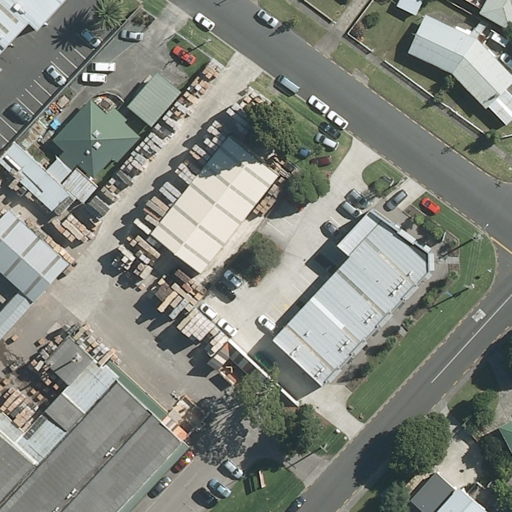

<class 'numpy.ndarray'>


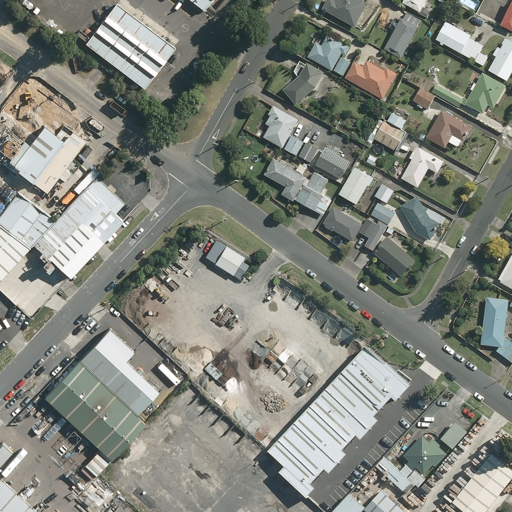

<class 'numpy.ndarray'>


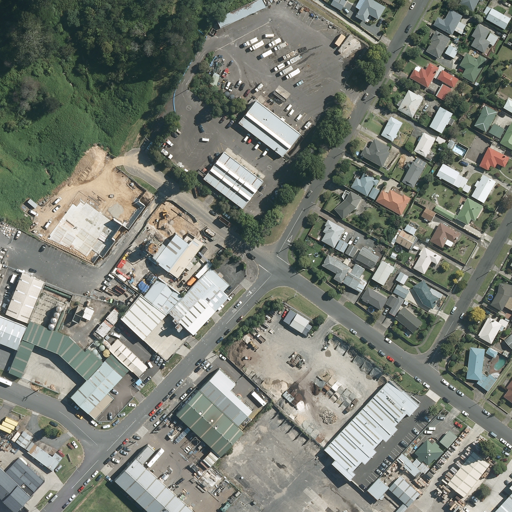

<class 'numpy.ndarray'>


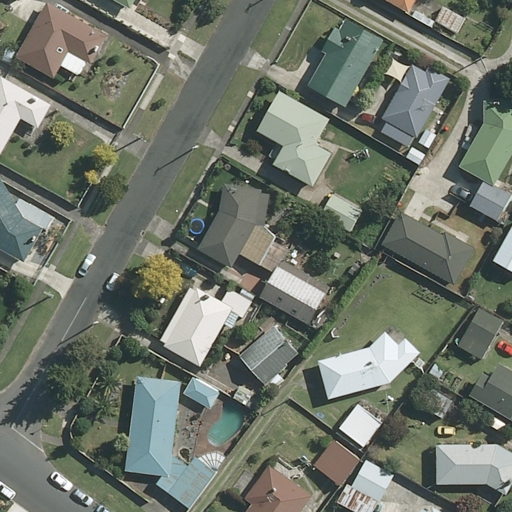

<class 'numpy.ndarray'>


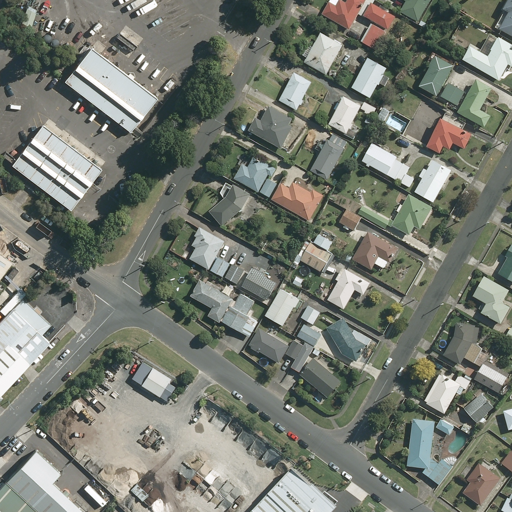

<class 'numpy.ndarray'>


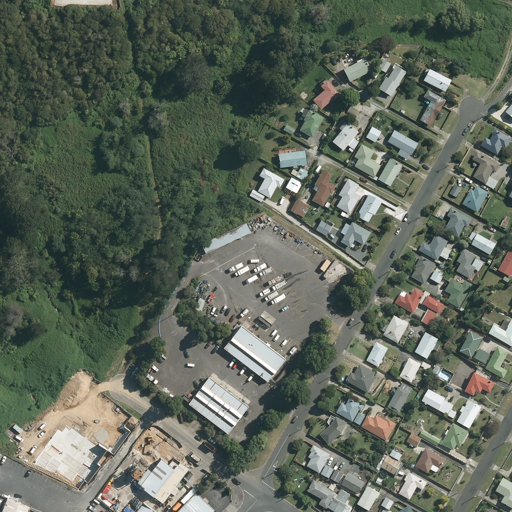

<class 'numpy.ndarray'>


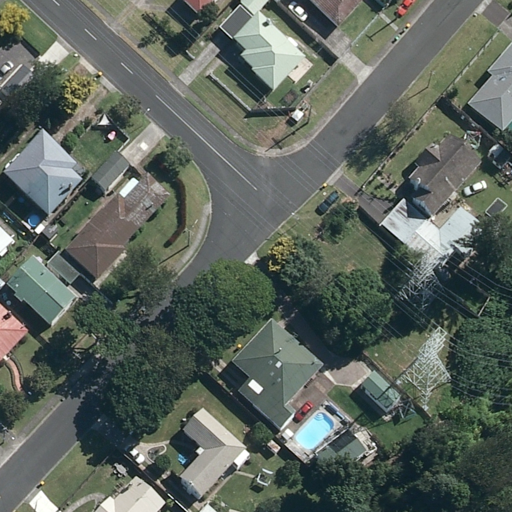

<class 'numpy.ndarray'>


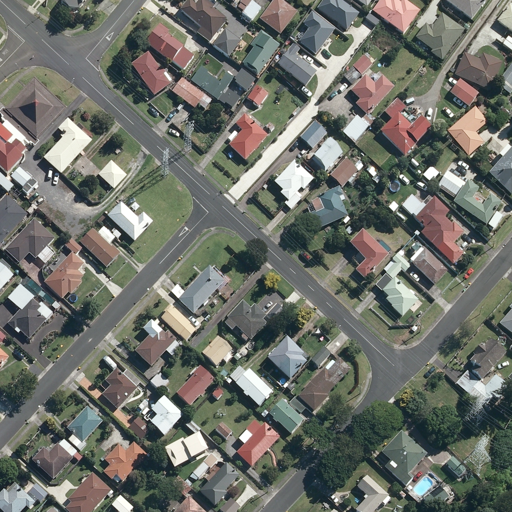

<class 'numpy.ndarray'>


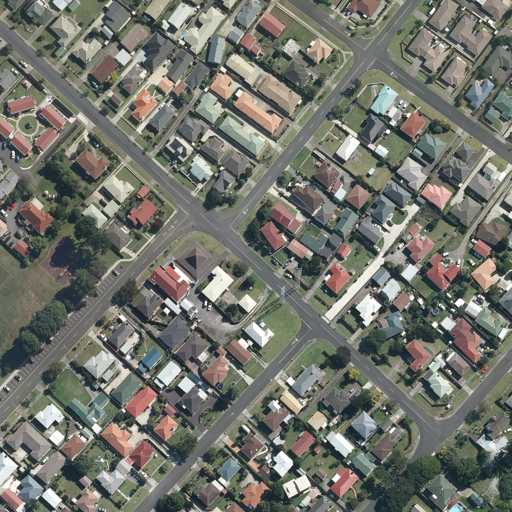

In [ ]:
import cv2, random
from google.colab.patches import cv2_imshow
import json

base_path = '/content/drive/MyDrive/hertie_master_projects/testtest' 

val_or_train = "train" # write a string here (either "val" or "train")
location = ""

dataset_dicts = json.load(open(f'{base_path}/testtest_{val_or_train}_0.2/labels.json'))
resolution_set = [.2,.4,.6]

for d in random.sample(dataset_dicts['images'], 3):  

    for res in resolution_set:
        im = cv2.imread(f'{base_path}/testtest_{val_or_train}_{res}/data/{d["file_name"]}')
        print(type(im))

        cv2_imshow(im)

In [ ]:
def new_image_size(target_image_size, original_resolution, target_resolution):

    ratio = original_resolution / target_resolution
    new_image_size = np.array(target_image_size).astype(float) / ratio

    return np.ceil(new_image_size).astype(int)

if target_resolution is not None:

    scaled_size = new_image_size(size, res, target_resolution)
    scaled_width, scaled_height = scaled_size, scaled_size

    print(f'Pictures from {country} will have {scaled_size}x{scaled_size} pixels.')


else:
    scaled_height, scaled_width = height, width